In [1]:
!python -V

Python 3.9.12


In [2]:
!pip install pyarrow

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [69]:
import pickle

In [30]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

df['duration']=df.lpep_dropoff_datetime - df.lpep_pickup_datetime 

df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
df= df[((df.duration>=1) &(df.duration<=60))]

categorical=['PULocationID', 'DOLocationID']

df[categorical]=df[categorical].astype(str)

In [31]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [12]:
df=df[df.trip_type ==2]

/home/mlops_zoomcamp/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

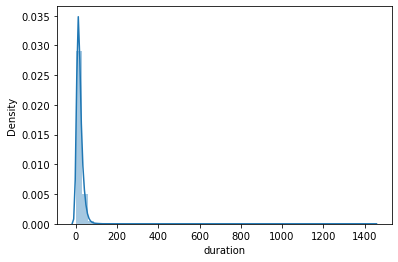

In [34]:
sns.distplot(df.duration)

In [35]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [37]:
df= df[((df.duration>=1) &(df.duration<=60))]

In [38]:
categorical=['PULocationID', 'DOLocationID']
numerical=['trip_distance']

In [39]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [40]:
df[categorical]=df[categorical].astype(str)

In [41]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [53]:
def read_df(filename):
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration']=df.lpep_dropoff_datetime - df.lpep_pickup_datetime 

    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    df= df[((df.duration>=1) &(df.duration<=60))]

    categorical=['PULocationID', 'DOLocationID']

    df[categorical]=df[categorical].astype(str)
    return df

In [55]:
filename_train ='./data/green_tripdata_2021-01.parquet'
filename_val = './data/green_tripdata_2021-02.parquet'
df_train = read_df(filename_train)
df_val = read_df(filename_val)

In [57]:
len(df_train), len(df_val)

(73908, 61921)

In [64]:
df_train['PU_DO'] = df_train['PULocationID']+'_'+df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID']+'_'+df_val['DOLocationID']


In [65]:
dv = DictVectorizer()

categorical= ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical=['trip_distance']

train_dicts = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [66]:
y_train = df_train['duration'].values
y_val = df_val['duration'].values

In [67]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.4793657829373155

In [72]:
with open ('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)

In [68]:
la = Lasso(alpha = 0.001)
la.fit(X_train,y_train)

y_pred = la.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.233436225720547

In [45]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [46]:
y_train = df['duration'].values

In [47]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [48]:
y_pred = lr.predict(X_train)

/home/mlops_zoomcamp/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mlops_zoomcamp/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


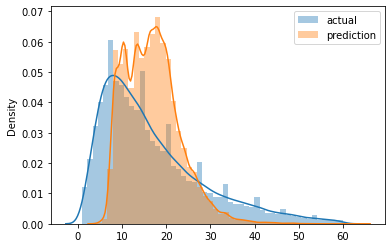

In [49]:
sns.distplot(y_train, label ='actual')
sns.distplot(y_pred, label ='prediction')
plt.legend()

In [51]:
mean_squared_error(y_train, y_pred, squared=False)

9.775464278878395

In [ ]:
la = Lasso()
la.fit(X_train,y_train)
y_pred = la.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)